In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# Load trades
trades = pd.read_csv("../Data/project2_trading.csv")

print("Trades sample:")
print(trades.head())


Trades sample:
     trade_id instrument_id                      timestamp trade_type  \
0  TRD_000001    INST_00516  2024-01-01 00:00:00.000000000       SELL   
1  TRD_000002    INST_00818  2024-01-01 00:11:39.863328777        BUY   
2  TRD_000003    INST_00283  2024-01-01 00:23:19.726657555        BUY   
3  TRD_000004    INST_00138  2024-01-01 00:34:59.589986332       SELL   
4  TRD_000005    INST_00931  2024-01-01 00:46:39.453315110       SELL   

   order_type       strategy  quantity        price  execution_price  \
0      MARKET  PAIRS_TRADING     86786  2366.978206      4228.998055   
1       LIMIT  PAIRS_TRADING     44460   245.020274      1939.500465   
2       LIMIT      ARBITRAGE     69063  1182.449102      2909.052347   
3  STOP_LIMIT  PAIRS_TRADING      5099  3582.864991       717.500193   
4      MARKET  MARKET_MAKING     16791   434.698012      3995.291578   

   slippage_bps  commission_usd  market_impact_bps       pnl_usd  \
0     45.693144      123.557611          27.1

In [5]:
# Create returns per instrument
returns = trades.pivot_table(
    index="timestamp", 
    columns="instrument_id", 
    values="pnl_usd"
).pct_change().dropna()

print("Returns matrix shape:", returns.shape)
returns.head()


C:\Users\prasa\AppData\Local\Temp\ipykernel_44900\2136591193.py:6: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ).pct_change().dropna()


Returns matrix shape: (18991, 1500)


instrument_id,INST_00001,INST_00002,INST_00003,INST_00004,INST_00005,INST_00006,INST_00007,INST_00008,INST_00009,INST_00010,...,INST_01491,INST_01492,INST_01493,INST_01494,INST_01495,INST_01496,INST_01497,INST_01498,INST_01499,INST_01500
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-03-30 04:13:15.386512884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-30 04:24:55.249841662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-30 04:36:35.113170440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-30 04:48:14.976499217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-03-30 04:59:54.839827995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Momentum Strategy = go long if last return > 0, short if < 0
def momentum_strategy(ret_series):
    return np.where(ret_series.shift(1) > 0, 1, -1)

# Mean Reversion Strategy = go long if last return < 0, short if > 0
def mean_reversion_strategy(ret_series):
    return np.where(ret_series.shift(1) < 0, 1, -1)


In [7]:
def backtest_strategy(returns, strategy_func, cost_bps=10):
    signals = returns.apply(strategy_func)
    
    # PnL = signal * returns
    pnl = signals * returns
    
    # Transaction costs
    tc = (cost_bps/10000) * abs(signals.diff()).sum(axis=1)
    pnl_after_costs = pnl.sum(axis=1) - tc
    
    return pnl_after_costs.cumsum(), pnl_after_costs


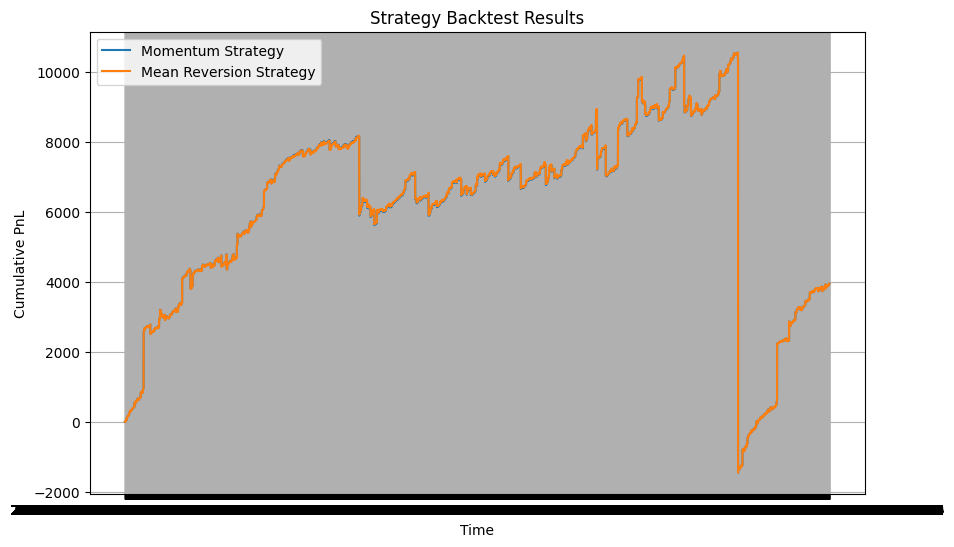

In [8]:
momentum_cum, momentum_daily = backtest_strategy(returns, momentum_strategy)
mr_cum, mr_daily = backtest_strategy(returns, mean_reversion_strategy)

plt.figure(figsize=(10,6))
plt.plot(momentum_cum, label="Momentum Strategy")
plt.plot(mr_cum, label="Mean Reversion Strategy")
plt.legend()
plt.title("Strategy Backtest Results")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.show()


In [9]:
def max_drawdown(series):
    roll_max = series.cummax()
    drawdown = (series - roll_max) / roll_max
    return drawdown.min()

# Evaluate performance
results = pd.DataFrame({
    "Strategy": ["Momentum", "Mean Reversion"],
    "Total Return": [momentum_cum.iloc[-1], mr_cum.iloc[-1]],
    "Volatility": [momentum_daily.std(), mr_daily.std()],
    "Sharpe": [momentum_daily.mean()/momentum_daily.std(), 
               mr_daily.mean()/mr_daily.std()],
    "Max Drawdown": [max_drawdown(momentum_cum), max_drawdown(mr_cum)]
})

print("Backtest Performance:")
print(results)


Backtest Performance:
         Strategy  Total Return  Volatility    Sharpe  Max Drawdown
0        Momentum   3944.982511   93.921668  0.002212     -1.138180
1  Mean Reversion   3943.917802   93.921680  0.002211     -1.138244


In [10]:
results.to_csv("backtest_results.csv", index=False)
print("Backtest results saved: backtest_results.csv")


Backtest results saved: backtest_results.csv


In [11]:
def walk_forward_validation(returns, strategy_func, train_size=0.7, cost_bps=10):
    """
    Walk-forward validation for strategies.
    train_size: % of data for training in each window
    """
    n = len(returns)
    window = int(train_size * n)
    
    all_pnls = []
    
    for start in range(0, n - window, int(window/2)):  # rolling window (50% overlap)
        train = returns.iloc[start:start+window]
        test = returns.iloc[start+window:start+window+int(window/2)]
        
        # Apply strategy on test data
        signals = test.apply(strategy_func)
        pnl = signals * test
        
        # Transaction costs
        tc = (cost_bps/10000) * abs(signals.diff()).sum(axis=1)
        pnl_after_costs = pnl.sum(axis=1) - tc
        
        all_pnls.append(pnl_after_costs)
    
    combined_pnl = pd.concat(all_pnls).sort_index()
    return combined_pnl.cumsum(), combined_pnl


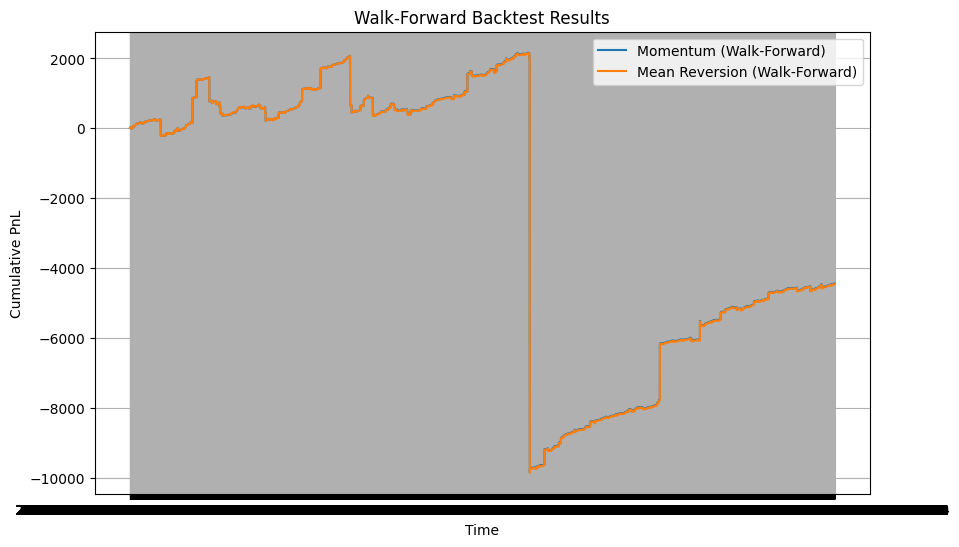

In [12]:
momentum_cum_wf, momentum_daily_wf = walk_forward_validation(returns, momentum_strategy)
mr_cum_wf, mr_daily_wf = walk_forward_validation(returns, mean_reversion_strategy)

# Plot cumulative PnL
plt.figure(figsize=(10,6))
plt.plot(momentum_cum_wf, label="Momentum (Walk-Forward)")
plt.plot(mr_cum_wf, label="Mean Reversion (Walk-Forward)")
plt.legend()
plt.title("Walk-Forward Backtest Results")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL")
plt.grid(True)
plt.show()


In [13]:
results_wf = pd.DataFrame({
    "Strategy": ["Momentum (WF)", "Mean Reversion (WF)"],
    "Total Return": [momentum_cum_wf.iloc[-1], mr_cum_wf.iloc[-1]],
    "Volatility": [momentum_daily_wf.std(), mr_daily_wf.std()],
    "Sharpe": [momentum_daily_wf.mean()/momentum_daily_wf.std(), 
               mr_daily_wf.mean()/mr_daily_wf.std()],
    "Max Drawdown": [max_drawdown(momentum_cum_wf), max_drawdown(mr_cum_wf)]
})

print("Walk-Forward Backtest Performance:")
print(results_wf)


Walk-Forward Backtest Performance:
              Strategy  Total Return  Volatility    Sharpe  Max Drawdown
0        Momentum (WF)  -4443.298110  161.430308 -0.004831     -5.553010
1  Mean Reversion (WF)  -4458.280475  161.430334 -0.004847     -5.590505


In [15]:
results_wf.to_csv("backtest_results_walkforward.csv", index=False)
print("Walk-Forward results saved: backtest_results_walkforward.csv")


Walk-Forward results saved: backtest_results_walkforward.csv
